# Bayesian neural networks with Pyro

This notebook uses Pyro to train a Bayesian neural network. This notebook is adapted from: https://github.com/paraschopra/bayesian-neural-network-mnist/blob/master/bnn.ipynb and http://pyro.ai/examples/bayesian_regression.html, written by Ben Moseley.

<img src="https://pyro.ai/img/pyro_logo.png" width="100" align="left"/>

# Bayesian neural networks

In the previous part, we used Pyro to define probabilistic models in which their random variables represented **physically relevant features** (such as the weight of an object, and the temperature outside) of the world.

Another possibility is to define a **black-box** probabilistic model, where its (latent or unobserved) random variables do not have physically salient meanings, but its inputs and outputs nonetheless describe meaningful things about the world.

From this viewpoint, we could image a neural network as a probabilistic model, where it's **weights are latent random variables**, and its output is a random variable which depends on the weights and the inputs of the network. More precisely, defining some weights $w$, and input and output variables $x$ and $y$, the neural network is used to model $P(y | w, x)$.

A common choice is to assume this distribution is a Normal distribution, such that

$
P(y | w, x) = \mathcal{N} (y; \mu= f(w,x), \sigma^{2}=1)~,
$

Where $f(w,x)$ is the output of the neural network. In theory, if we define a **prior** on the neural network weights $w$, we could use Pyro (or any PPL) in exactly the same way as we did in the previous part to infer the posterior distribution of the weights $P(w | \mathcal{D})$, given some training data (observations) $\mathcal{D}=\{(x_1,y_1),...(x_n,y_n)\}$. A psuedo-function for the Pyro model would be:

``` 
def model(x, y=None):
    "Pyro BNN model"
    
    w = pyro.sample('w', some-prior-distribution)
    y = pyro.sample('y', dist.Normal(neural-net(w,x), 1), obs=y)
    return y
```

Note, in this approach, $x$ is not considered a random variable (i.e. it is deterministic), but Pyro allows us to pass different values of $x$ to the model by defining it as an input to the stochastic function.

In practice, Pyro provides some additional **high-level features** (in particular, `pyro.nn`) that are useful when defining probabilistic models with neural networks which we will use below.

# The task

Our goal is to classify MNIST images. Crucially, instead of just training a normal neural network, we want to design a network which is able to say when it **doesn't know** the right answer (say, for example when we feed the network an image of letter instead of a number). To do this we will train a Bayesian Neural Network (BNN) in Pyro, and output a predictive posterior distribution over the labels. Example images from MNIST are shown below:

<img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png" width="500" style="float: none;"/>

This task consists of multiple stages:

- Step 1: load the training/ test data
- Step 2: train a standard NN model
- Step 3: define a BNN model
- Step 4: train the model using SVI
- Step 5: validate the results on test data

In [2]:
import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

pyro.set_rng_seed(101)

## Step 1: load the training/ test data

Below we download the MNIST dataset.

In [3]:
train_dataset = datasets.MNIST('./data', train=True, download=True,
                               transform=transforms.Compose([
                               transforms.ToTensor(),
                               ]))

test_dataset = datasets.MNIST('./data', train=False, download=True,
                              transform=transforms.Compose([
                              transforms.ToTensor(),
                              ]))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=128, shuffle=True)

0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/home/faiz/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370124688/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


> **Task 1**: plot a selection of the train/ test images.

In [18]:
## TODO: write some code here
n_train = len(train_loader.dataset)
n_test = len(test_loader.dataset)
train_samples = list(train_loader.dataset)[::(n_train // 10)]
test_samples = list(test_loader.dataset)[::(n_test // 10)]

In [21]:
display_image = lambda x: display(transforms.ToPILImage()(1 - x).convert("L"))
print("Images from train set")
for i in range(10):
    display_image(train_samples[i][0])
print("Images from test set")
for i in range(10):
    display_image(test_samples[i][0])

Images from train set


Images from test set


## Step 2: train a standard NN model

Before we train a BNN, we will train a standard NN classifier to compare our results to. We take the standard approach to classifying MNIST digits using a cross entropy loss, e.g. see here https://github.com/pytorch/examples/blob/master/mnist/main.py : 

In [42]:
class NN(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, output_size)
        self.relu = torch.nn.ReLU()
        self.log_softmax = torch.nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.log_softmax(x)# output (log) softmax probabilities of each class
        return x

nn = NN(28*28, 512, 10)

> **Task 2**: train this neural network over 5 epochs using the loss function and optimizer given below.

In [52]:
print("resetting parameters")
for l in nn.children():
    if hasattr(l, 'reset_parameters'):
        print("*", end="")
        l.reset_parameters()
print()
loss_function = torch.nn.NLLLoss()# negative log likelihood loss
optimizer = torch.optim.Adam(nn.parameters(), lr=0.01)
num_epochs = 5
for epoch in range(5):
    print("epoch #"+str(epoch+1), end="")
    nn.train()
    train_loss = 0.0
    for batch in train_loader:
        nn.zero_grad()
        x, y = batch
        output = nn(x)
        loss = loss_function(output, y)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(", LOSS: "+str(train_loss))


resetting parameters
**
epoch #1, LOSS: 97.05375009030104
epoch #2, LOSS: 50.13629272673279
epoch #3, LOSS: 40.180238818516955
epoch #4, LOSS: 38.45476999343373
epoch #5, LOSS: 33.19764643674716


> **Task 3**: report the average prediction accuracy across the test dataset.

In [47]:
with torch.no_grad():
    test_perf = 0.0
    for batch in test_loader:
        nn.zero_grad()
        x, y = batch
        output = nn(x).argmax(dim=1)
        batch_perf = (y == output).sum().item()
        test_perf += batch_perf
average_test_perf = test_perf / len(test_loader.dataset)
print("Test set accuracy: " + str(average_test_perf))

Test set accuracy: 0.9682


### Testing outside of the training distribution

Next, we plot the predictions of the standard NN outside of its training distribution: i.e. on images which we expect the NN should not know the right answer.

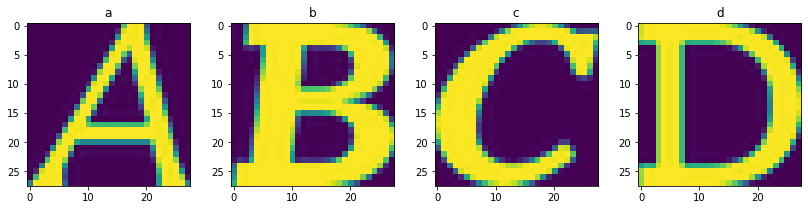

In [57]:
# load the test letter dataset
letters = ["a","b","c","d","e","f","g","h","i","j"]
x_letters = np.array([np.array(Image.open("data/not-mnist/%s.png"%(l)))
                         for l in letters]).astype(np.float32)# loads letters data
x_letters /= np.max(x_letters, axis=(1,2), keepdims=True)# normalise
x_letters = torch.from_numpy(x_letters)

# plot the letters test data
plt.figure(figsize=(14,3))
for iplot,i in enumerate([0,1,2,3]):
    plt.subplot(1,4,iplot+1)
    plt.imshow(x_letters[i].numpy())
    plt.title(letters[i])
plt.show()

> **Task 4**: plot the predicted softmax probability distribution over each class for each of these test letters.

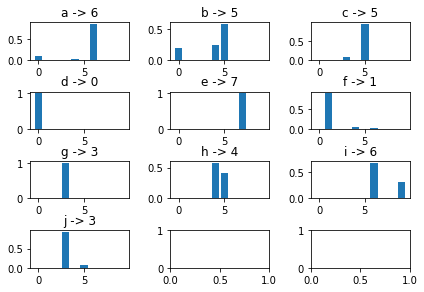

In [75]:
fig, axs = plt.subplots(4, 3)
fig.tight_layout()
with torch.no_grad():
    for i in range(10):
        row = i // 3; col = i % 3
        probabilities = torch.exp(nn(x_letters[i]))
        axs[row, col].bar(range(10), height=probabilities[0])
        axs[row, col].set_title(letters[i] + " -> " + str(probabilities[0].argmax().item()))
        

## Step 3: define a BNN model

It appears the standard network makes *overconfident predictions* on the test data outside of its training distribution.

Note, from a probabilistic perspective, the code above defines a neural network which models the labels as a categorical distribution, and the network is trained by maximising the log-likelihood of the training data. i.e., we are making an MLE point estimate of the trainable parameters of the network.

This doesn't require specifying a prior over the parameters of the network, nor does it model the full posterior distribution over the parameters (instead it just gives us a point estimate).

Instead, we will train a BNN using Pyro to do the same task, this time specifying priors over the parameters, and approximating their full posterior distribution using SVI.

In [118]:
PyroLinear = pyro.nn.PyroModule[torch.nn.Linear]
    
class BNN(pyro.nn.PyroModule):
    
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        
        self.fc1 = PyroLinear(input_size, hidden_size)
        self.fc1.weight = pyro.nn.PyroSample(dist.Normal(0., 1.).expand([hidden_size, input_size]))
        self.fc1.bias   = pyro.nn.PyroSample(dist.Normal(0., 1.).expand([hidden_size]))
        
        self.fc2 = PyroLinear(hidden_size, output_size)
        self.fc2.weight = pyro.nn.PyroSample(dist.Normal(0., 1.).expand([output_size, hidden_size]))
        self.fc2.bias   = pyro.nn.PyroSample(dist.Normal(0., 1.).expand([output_size]))
        
        self.relu = torch.nn.ReLU()
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, y=None):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.log_softmax(x)# output (log) softmax probabilities of each class
        
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Categorical(logits=x), obs=y)
            
bnn = BNN(28*28, 512, 10)

The code above is the Pyro BNN equivalent to the PyTorch NN class defined above.

There is a lot going on, and we break this down below:
- Instead of defining *stochastic functions*, Pyro allows us to define *stochastic modules* as probabilistic models. We can think of these as an extension of PyTorch's `nn.Module` class, allowing us to use the same idiom but enabling their Bayesian treatment with Pyro.
- We can "Pyro-ize" an existing PyTorch module by using the `pyro.nn.PyroModule[torch.nn.Linear]` metaclass constructor, or by subclassing `pyro.nn.PyroModule`. All modules in the model need to be "Pyro-ized" for this to be a valid Pyro module.

We define the network in a very similar way, except for some important changes:
- We turn the weights and biases into random variables by using `pyro.nn.PyroSample`: this is the equivalent of `pyro.sample` for creating stochastic `pyro.nn.PyroModule` attributes. Now, every time we call `.forward` above, a new set of weights and biases are sampled from their prior distributions. Note whilst `pyro.sample` requires a name string, Pyro handles the naming of `pyro.nn.PyroSample` attributes automatically.
- The `.expand([hidden_size, input_size])` allows us to define multiple univariate distributions which are conditionally independent.
- The `pyro.plate` context manager allows us to explicitly state that the observations are conditionally independent across the batch dimension of the network's inputs, which can speed up the underlying inference.
- Note the basic elements of a Pyro model are present: we define some unobserved random variables (the weights and biases of the network), and an observed random variable (the output of the network), using the `obs=` argument.

For more on `pyro.nn.PyroModule`, see: http://pyro.ai/examples/tensor_shapes.html and http://pyro.ai/examples/modules.html.

> **Task 5**: Define a SVI guide function to train the BNN. Define separate (independent) univariate normal distributions for each parameter.

Hint: the name strings automatically assigned to the BNN's parameters are: `"fc1.weight"`, `"fc1.bias"`, `"fc2.weight"`, and `"fc2.bias"`.

In [115]:
import torch.nn.functional as F

def guide(x, y=None):
    fc1_weight = pyro.param("fc1.weight", dist.Normal(0., 1.).expand([512, 28*28]))
    fc1_bias = pyro.param("fc1.bias", dist.Normal(0., 1.).expand([512]))
    fc2_weight = pyro.param("fc2.weight", dist.Normal(0., 1.).expand([10, 512]))
    fc2_bias = pyro.param("fc2.bias", dist.Normal(0., 1.).expand([10]))
    x0 = fc1_weight.matmul(x)
    x1 = x0 + fc1_bias
    x2 = F.relu(x1)
    x3 = fc2_weight.matmul(x2)
    x4 = x3 + fc2_bias
    return pyro.sample("guide_obs", dist.Categorical(logits=F.log_softmax(x4)), obs=y)

### Autoguides

Note, Pyro makes defining guides even easier with autoguides: for example, we could have achieved a similar guide using `guide = pyro.infer.autoguide.AutoDiagonalNormal(bnn)` above. See here for more info: http://docs.pyro.ai/en/stable/infer.autoguide.html

In [119]:
guide = pyro.infer.autoguide.AutoDiagonalNormal(bnn)
# print(guide)

### On the guide approximation

Note, assuming independent distributions for each set of parameters is quite a strong assumption, and could lead to a poor posterior approximation; see here for a discussion: http://pyro.ai/examples/bayesian_regression_ii.html

## Step 4: train the model using SVI

Finally, we are ready to train the model. This is very similar to training the models using SVI from the previous part.

> **Task 6**: train the BNN, using the optimizer and network structure defined below.

Hint: we can pass training data to SVI using `svi.step(x, y)`.

In [133]:
from tqdm import tqdm
pyro.clear_param_store()
svi = SVI(model=bnn, 
          guide=guide, 
          optim=Adam({"lr": 1e-2}), 
          loss=Trace_ELBO(num_particles=1))
num_epochs = 5

for epoch in range(5):
    num_samples = 0
    train_loss = 0.0
    epoch_iter = tqdm(train_loader, position = 0, leave=True)
    for batch in epoch_iter:
        num_samples += len(batch)
        x, y = batch
        train_loss += svi.step(x, y)
        epoch_iter.set_description(f"Epoch {epoch+1}/{num_epochs}, current training loss: {round(train_loss/num_samples, 4)}")



Epoch 5/5, current training loss: 3421.1227: 100%|██████████| 469/469 [00:19<00:00, 23.91it/s]


> **Task 7**: report the average prediction accuracy across the test dataset.

Hint: we can use `predictive = pyro.infer.Predictive(model=bnn, guide=guide, num_samples=10)` to obtain a function that will sample from the predictive posterior distribution of the BNN, given an input `x` (i.e. it calls .forward using network parameters sampled from the guide). You can take the mode of the predicted class samples to be the network prediction.

In [132]:
predictive = pyro.infer.Predictive(model=bnn, guide=guide, num_samples=100)
test_perf = 0.0
for batch in tqdm(test_loader, position = 0, leave=True):
    x, y = batch
    output = torch.mode(predictive(x)["obs"], dim=0).values
    batch_perf = (y == output).sum().item()
    test_perf += batch_perf
average_test_perf = test_perf / len(test_loader.dataset)
print("Test set accuracy: " + str(average_test_perf))


100%|██████████| 79/79 [01:08<00:00,  1.16it/s]

Test set accuracy: 0.8921


## Step 5: validate the results on test data

Now we are ready to test the predictions of the BNN on the letters dataset. You should find that the network is much more uncertain about its predictions!

> **Task 8**: plot the predictive posterior distribution over each class for each of the test letters.

Hint: we can again use `predictive` to draw samples from the predictive posterior distribution. You can estimate the distribution by plotting the histogram of counts in each class for each letter.

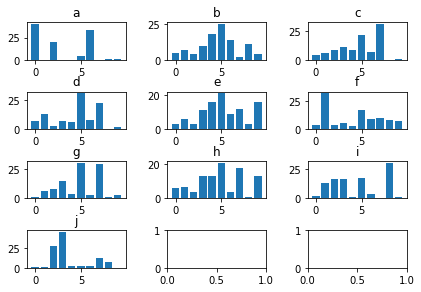

In [141]:
## TODO: write some code here
fig, axs = plt.subplots(4, 3)
fig.tight_layout()
for i in range(10):
    row = i // 3; col = i % 3
    samples = predictive(x_letters[i])["obs"].squeeze(1)
    frequencies = [len([j for j in samples if j == k]) for k in range(10)]
    axs[row, col].bar(range(10), height=frequencies)
    axs[row, col].set_title(letters[i])


## Possible extensions

We mentioned above that our SVI implementation makes a strong assumption about the form of the posterior distribution. Here are a few possible extension questions/ tasks:

> **(Extension) Question 1**: What other guide functions could you use? How does their computational complexity scale?

> **(Extension) Question 2**: How would MCMC methods (e.g. HMC) cope for this problem?

> **(Extension) Task 1**: Try experimenting with other guides in: http://docs.pyro.ai/en/stable/infer.autoguide.html  such as `AutoLowRankMultivariateNormal`.